In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('data/enterprise_saas_v3.csv')
df = df.set_index('ticker')

df_y = pd.DataFrame(df['px_chg'], columns=['px_chg'], index=df.index.values)
df_x = df.drop(columns=['px_chg', 'ev_chg', 'eqy_c', 'ev_c', 'sales_ev', 'sales2_ev', 'ebitda_ev', 'net_debt_ev', 'sales_chg_fwd', 'sales_chg_ltm', 'ebitda_chg_fwd', 'sales_chg_qoq'])
df_x.head()

,val_trade,si_ratio,salesh_ev,ebitda2_ev,debt_ev,sales_chg_2fwd,ebitda_chg_2fwd
ticker,,,,,,,
WLN FP Equity,21241410.00,0.0,4.428875,0.059901,0.034626,0.072148,0.007550
NRO FP Equity,78419.01,0.0,0.709236,0.170324,0.001321,0.046406,0.007398
CGM FP Equity,735718.80,0.0,0.970630,0.173515,0.379215,0.040506,0.011547
ALESK FP Equity,377294.50,0.0,3.674706,0.056290,0.020423,0.146353,0.008564
HO FP Equity,29819110.00,0.0,1.366972,0.099046,0.253832,0.076014,0.009640


In [8]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(df_x.values)
Y_norm = scaler.fit_transform(df_y.values)

df_x_norm = pd.DataFrame(X_norm, columns=df_x.columns, index=df_x.index.values)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_norm)
pca.explained_variance_ratio_

array([0.39160835, 0.17009343, 0.14669242, 0.12705248])

In [9]:
df_comps = pd.DataFrame(pca.components_, columns=df_x.columns)
df_comps

,val_trade,si_ratio,salesh_ev,ebitda2_ev,debt_ev,sales_chg_2fwd,ebitda_chg_2fwd
0,0.069731,-0.151866,0.481815,-0.507232,-0.434828,0.473037,-0.264204
1,0.577768,-0.684382,-0.080129,0.234997,-0.107296,-0.222857,-0.273831
2,0.423425,-0.072627,-0.244571,-0.144448,-0.099005,0.350795,0.775821
3,0.647733,0.526553,0.302509,0.107809,0.382710,0.123489,-0.195787


<IPython.core.display.Javascript object>


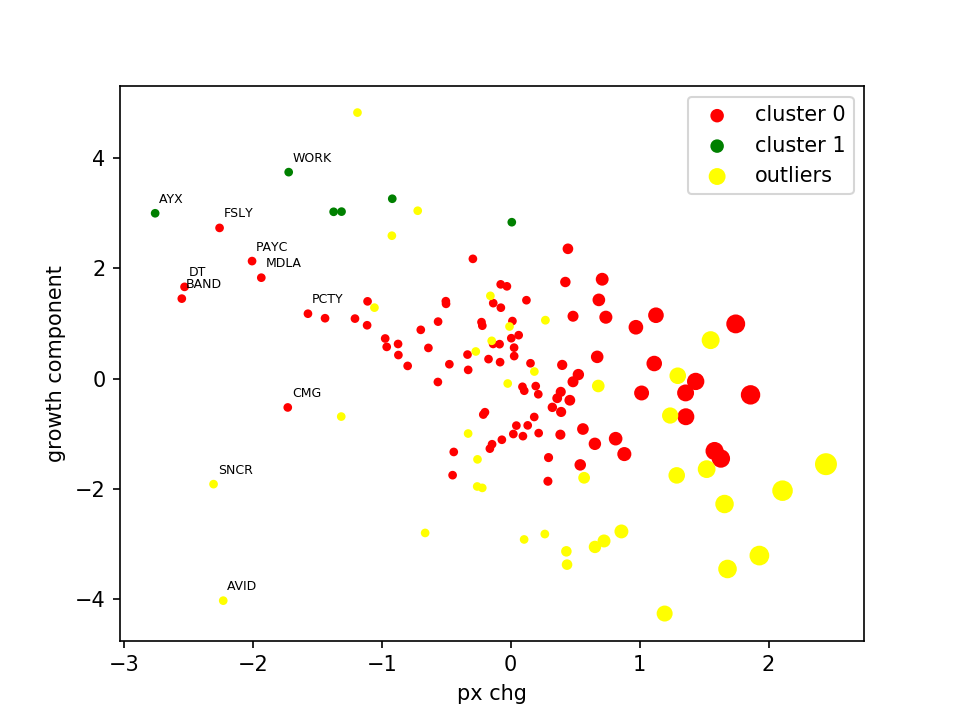

In [20]:
cluster_counts = []
steps = 40
eps = np.linspace(0.6, 1.5, num=steps)
for i in range(steps):
    clusters = DBSCAN(eps=eps[i], min_samples=5).fit(X_pca)
    cluster_counts.append(len(set(clusters.labels_)))

plt.clf()
plt.plot(eps, cluster_counts, 'ro')
plt.xlabel('eps')
plt.ylabel('clusters')
plt.show()

In [12]:
clustering = DBSCAN(eps=0.85, min_samples=5).fit(X_pca)
print(f'{len(set(clustering.labels_))} including outlier')

coefs = np.corrcoef(np.concatenate((X_pca, Y_norm), axis=1), rowvar=False)
coefs[-1, :-1]

3 including outlier


array([-0.44167938, -0.12073146,  0.23124217, -0.09601781])

In [56]:
plt.clf()

colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'black', 'yellow']
c = [colors[l] for l in clustering.labels_]

yax = 0
xax = 1
zax = 2

s = [max(10, v*500) for v in df_y['px_chg']]

clust_labels = list(set(clustering.labels_))
cluster_idxs = [np.where(clustering.labels_ == i, True, False) for i in clust_labels]

for (clabel, cidx) in zip(clust_labels, cluster_idxs):
    if clabel == -1:
        l = 'outliers'
    else:
        l = f'cluster {clabel}'
        
    cc = np.array(c)[cidx]
    ss = np.array(s)[cidx]
    plt.scatter(Y_norm[cidx], X_pca[cidx,yax], label=l, c=cc, s=ss)
# plt.scatter(X_pca[:,xax], X_pca[:,yax], c=c, s=s)
# plt.scatter(Y_norm, df_x_norm['salesh_ev'], c=c)
# plt.ylabel('sales x')

plt.xlabel('px chg')
plt.ylabel(f'growth component')

legend = plt.legend()
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]

for i, pt in enumerate(X_pca):
    # (clustering.labels_[i] == 1 or clustering.labels_[i] == 0)
    if Y_norm[i] < -1.5:
        plt.annotate(df_x.index[i].split(' ')[0], xy=(Y_norm[i], pt[yax]),
                     xytext=(2, 5), textcoords='offset points', fontsize=6)

plt.show()

for i, idxs in enumerate(cluster_idxs):
    cluster = X_pca[idxs]
    cluster_coefs = np.corrcoef(np.concatenate((X_pca[idxs], Y_norm[idxs]), axis=1), rowvar=False)
    print(f'cluster {clust_labels[i]} ({colors[clust_labels[i]]}) corr coefs to px: {cluster_coefs[-1, :-1]}')

cluster 0 (red) corr coefs to px: [-0.41242081  0.02714008  0.18794304 -0.15921524]
cluster 1 (green) corr coefs to px: [-0.26413777  0.13186204 -0.7860833  -0.01709162]
cluster -1 (yellow) corr coefs to px: [-0.30530822 -0.25730226  0.24777838 -0.13927779]
